# **Modeling: Retail ActionAI: Next-Best-Offer**

## **Modeling & Decision Engine - Notebook Plan**  

This notebook takes the cleaned **`candidates`** matrix and turns it into a calibrated “buy-next” model plus the business rules that convert probabilities into offers.  
No code below—just the play-by-play of what each section will do.

---

**Quick Feature Checks**

* **Pearson correlation** on numeric columns  
* **Mutual information** on numeric + categorical columns &rarr; rank useful predictors; drop MI &asymp; 0 if we need to slim width.  
* Result: a leaner, high-signal feature set.

**Train/Test Split & CatBoost Encoding**

* 80 / 20 split, stratified on `bought_next`.  
* Low-cardinality categoricals (`aisle`, `department`, `peak_dow`) encoded with **CatBoostEncoder** (target-aware, leakage-safe).  
* Numeric features stay as-is; long-tail columns were winsorised earlier.

**Modeling**

Train five imbalance-aware tree ensembles:  

| model | imbalance trick |
|-------|-----------------|
| Random Forest | `class_weight='balanced'` |
| LightGBM | `class_weight='balanced'` |
| XGBoost | `scale_pos_weight &asymp; 15` |
| Balanced Bagging (LightGBM base) | under-samples negatives in each bag |
| Easy Ensemble (LightGBM base) | AdaBoost on balanced bags |

Metrics collected: **ROC-AUC**, F1 and recall.  

**Next-Best-Offer Logic**

*For each user-product candidate in production:*  

* Get `p_buy` from the calibrated model.  
* Apply business rule thresholds:
  - If `p_buy > 0.8` &rarr; assign **"None"** (likely buyer; no incentive needed).
  - If `0.3 < p_buy ≤ 0.8`:
    - If user is **engaged** (`user_total_orders > 10` and `avg_basket_size > 5`) &rarr; assign **"Upsell"**.
    - Else &rarr; assign **"Coupon"**.
  - If `p_buy ≤ 0.3` &rarr; assign **"Coupon"** (low intent, needs incentive).
* This rule-based approach blends behavioral segmentation with predictive modeling.

**Save Artifacts**

* Calibrated model (`.pkl`)  
* CatBoost encoder (`.pkl`)  
* Final feature list  

With these pieces we can deploy a real-time API that scores the active cart, runs the EV maths, and surfaces the smartest next-best offer.


## **Importing Necessary Libraries**

In [2]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00


In [8]:
#Let's import the necessary packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Machine Learning models:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import category_encoders as ce #Catboost Encoder for Categoricals
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import joblib, json, pathlib

# Model evaluation:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report
import shap

# Handling class imbalance: They're faster, less error-prone, and more robust to noise than synthetic oversampling like SMOTE.
# In most of the cases imblearn models outperform SMOTE-based methods
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced

# Finally let's run below to customize notebook display:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Dealing with warnings:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## **Helper Functions**

In [4]:
def summarize(df):
    """
    Generate a summary for our df including: unique_count, data_types, missing_counts and missing_percentage
    """
    # No. of unique values for each column:
    unique_counts = df.nunique()
    # Data types of each column:
    data_types = df.dtypes
    # No. of missing (NaN) values in each column:
    missing_counts = df.isnull().sum()
    # Percentage of missing values in each column:
    missing_percentage = 100 * df.isnull().mean()
    # Concatenate the above metrics:
    summary_df = pd.concat([unique_counts, data_types, missing_counts, missing_percentage], axis=1)
    # Rename the columns for better readibility
    summary_df.columns = ['unique_count', 'data_types', 'missing_counts', 'missing_percentage']
    # Reset index to turn column names into a proper column:
    summary_df = summary_df.reset_index().rename(columns={'index': 'feature'})
    # Return summary df
    return summary_df
#-----------------------------------------------------------------------------------------------------------------#
def value_counts_with_percentage(df, column_name):
    # Calculate value counts
    counts = df[column_name].value_counts(dropna=False)

    # Calculate percentages
    percentages = df[column_name].value_counts(dropna=False, normalize=True) * 100

    # Combine counts and percentages into a DataFrame
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    })

    return result
#-----------------------------------------------------------------------------------------------------------------#
def split_dataset(X, y, test_size=0.20, val_size=0.10, random_state=1981, stratify=True):
  """
  Split dataset into train, validation, and test sets.
  """
  stratify_y = y if stratify else None

  # First, let's split into train+val and test:
  X_temp, X_test, y_temp, y_test = train_test_split(
      X, y, test_size=test_size, random_state=random_state, stratify=stratify_y
  )

  # Then, let's recalculate validation size as a proportion of the remaining (X_temp):
  val_adjusted = val_size / (1 - test_size)
  stratify_y_temp = y_temp if stratify else None

  # Finally, let's split train and validation:
  X_train, X_val, y_train, y_val = train_test_split(
      X_temp, y_temp, test_size=val_adjusted, random_state=random_state, stratify=stratify_y_temp
  )

  return X_train, X_val, X_test, y_train, y_val, y_test

## **Importing Candidates Matrix Table**

First let's pull in the `candidates` dataset we saved after feature engineering.  
It holds one row per *(user_id, product_id)* pair, all engineered features, and the `bought_next` label.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Drive path where we stored the Parquet file:
CANDIDATE_PATH = "/content/drive/My Drive/Colab Notebooks/candidates_v2.parquet"

candidates = pd.read_parquet(CANDIDATE_PATH)

In [7]:
candidates.shape

(13307935, 30)

In [8]:
candidates.head()

,user_id,product_id,usr_prod_times_bought,last_order_number,days_since_last,last_cart_pos,orders_since_last,last_cart_pos_norm,user_total_orders,avg_basket_size,avg_reorder_ratio,avg_days_between,avg_order_hour,avg_order_dow,peak_hour,peak_dow,AM,PM,Even,<7,7-14,>14,hour_entropy,prod_total_orders,prod_times_reordered,aisle,department,prod_reorder_prob,prod_days_since_last_seen,bought_next
0,2,23,1,8,27,12,6,0.861538,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,1068,479,packaged poultry,meat seafood,0.448502,4,0
1,2,79,1,13,30,3,1,0.215385,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,3585,1916,canned meat seafood,canned goods,0.534449,0,0
2,2,1559,6,14,13,3,0,0.215385,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,6858,5023,yogurt,dairy eggs,0.732429,0,0
3,2,2002,4,11,30,14,3,1.000000,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,2832,1533,frozen vegan vegetarian,frozen,0.541314,1,0
4,2,2573,2,14,13,12,0,0.861538,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,1212,480,asian foods,international,0.396040,3,0


In [9]:
summary = summarize(candidates)
summary

,feature,unique_count,data_types,missing_counts,missing_percentage
0,user_id,206208,int32,0,0.0
1,product_id,49677,int32,0,0.0
2,usr_prod_times_bought,18,int64,0,0.0
3,last_order_number,99,int16,0,0.0
4,days_since_last,31,int16,0,0.0
5,last_cart_pos,34,int16,0,0.0
6,orders_since_last,99,int64,0,0.0
7,last_cart_pos_norm,128175,float64,0,0.0
8,user_total_orders,97,int64,0,0.0
9,avg_basket_size,18490,float64,0,0.0


## **Correlation**<a id='Correlation'></a>
[Contents](#Contents)

In this step, we aim to identify the most informative features related to buy_next prediction by evaluating their relationships with the target variable using multiple approaches. Specifically, we will be focusing on four main tasks:

* **Encoding Categorical Variables:** Converting all categorical features into numerical values using CatBoost encoding. This step ensures that we can effectively use these features in our analysis. We'll be converting all categorical features to numerical values using the **CatBoost** encoder from the **category_encoders** package. This encoding method handles categorical variables effectively, preserving their informational content.

* **Calculating Mutual Information:** Assessing the predictive power of each feature with respect to **buy_next** (independent from any modeling) by calculating the mutual information. Mutual information measures the dependency between the features and the target variable by calculating the mutual information for each feature with respect to **buy_next**. Mutual information provides a measure of the dependency between variables, allowing us to identify which features have the most predictive power.

* **Calculating Pearson Correlation:** Generating a heatmap to visualize the Pearson correlation coefficients between **buy_next** and all other features. This helps us understand the linear relationships in the dataset, although it is less informative for a binary target by calculating the Pearson correlation coefficients between **buy_next** and all other features. We visualize these correlations using a heatmap, which helps us easily identify strong linear relationships in the dataset.

In [10]:
candidates.columns

Index(['user_id', 'product_id', 'usr_prod_times_bought', 'last_order_number',
       'days_since_last', 'last_cart_pos', 'orders_since_last',
       'last_cart_pos_norm', 'user_total_orders', 'avg_basket_size',
       'avg_reorder_ratio', 'avg_days_between', 'avg_order_hour',
       'avg_order_dow', 'peak_hour', 'peak_dow', 'AM', 'PM', 'Even', '<7',
       '7-14', '>14', 'hour_entropy', 'prod_total_orders',
       'prod_times_reordered', 'aisle', 'department', 'prod_reorder_prob',
       'prod_days_since_last_seen', 'bought_next'],
      dtype='object')

In [11]:
#let's define slect our features:
features = [
    # user × product interaction:
    'usr_prod_times_bought', 'last_order_number', 'days_since_last',
    'last_cart_pos', 'orders_since_last', 'last_cart_pos_norm',
    # shopper-level:
    'user_total_orders', 'avg_basket_size', 'avg_reorder_ratio',
    'avg_days_between', 'avg_order_hour', 'avg_order_dow',
    'peak_hour', 'peak_dow', 'AM', 'PM', 'Even',
    '<7', '7-14', '>14', 'hour_entropy',
    # product-level:
    'prod_total_orders', 'prod_times_reordered', 'prod_reorder_prob',
    'prod_days_since_last_seen', 'aisle', 'department'
]

# Separate the features and target:
X = candidates[features]
y = candidates['bought_next']

### **CatBoost Encoding**<a id='Encoding'></a>
[Contents](#Contents)

In [12]:
# first let's select categorical columns:
categorical_cols = X.select_dtypes(include='category').columns.tolist()

# here we'll initialize CatBoost encoder for categorical columns only:
cbe_encoder = ce.CatBoostEncoder(cols=categorical_cols)

# then will fit encoder on full data:
cbe_encoder.fit(X[categorical_cols], y)

# transform categorical columns:
X_encoded = X.copy()
X_encoded[categorical_cols] = cbe_encoder.transform(X[categorical_cols])

In [13]:
# finally: Train-val-test split:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(
    X_encoded, y, test_size=0.20, val_size=0.10
)

**Here let's verify that the split worked as expected: Train 70%, Val 10%, Test 20%:**

In [14]:
def get_class_distribution_df(y, name=""):
    counts = y.value_counts()
    percentages = y.value_counts(normalize=True) * 100
    data = {
        "Set": [name] * len(counts),
        "Class": counts.index,
        "Count": counts.values,
        "Percentage": [round(p, 2) for p in percentages.values]
    }
    return pd.DataFrame(data)

In [15]:
df_summary = pd.concat([
    get_class_distribution_df(y, "Original"),
    get_class_distribution_df(y_train, "Train"),
    get_class_distribution_df(y_val, "Validation"),
    get_class_distribution_df(y_test, "Test")
], ignore_index=True)

df_summary

,Set,Class,Count,Percentage
0,Original,0,12479121,93.77
1,Original,1,828814,6.23
2,Train,0,8735384,93.77
3,Train,1,580170,6.23
4,Validation,0,1247913,93.77
5,Validation,1,82881,6.23
6,Test,0,2495824,93.77
7,Test,1,165763,6.23


### **Mutual Information - Prediction Power**<a id='MU'></a>
[Contents](#Contents)

Mutual Information (MI) is a measure of the mutual dependence between two variables. It quantifies the amount of information obtained about one variable through another variable. Unlike correlation, which only captures linear relationships, mutual information can capture both linear and non-linear relationships between variables, making it a powerful tool for feature selection in machine learning.

**Mutual Information key advanatages:**

* **Captures Non-Linear Relationships:** Unlike traditional correlation measures (e.g., Pearson), mutual information can capture complex, non-linear relationships between features and the target variable. This is particularly useful in real-world datasets where relationships are rarely purely linear.

* **Independence Detection:** A mutual information score of zero indicates that two variables are completely independent. Non-zero mutual information indicates some level of dependency.

* **Predictive Power:** Higher mutual information scores suggest that a feature contains more information about the target variable, indicating higher predictive power. This helps in identifying the most relevant features for building robust predictive models.

In [19]:
mi_vals = [
    mutual_info_classif(
        X_train.iloc[:, [i]],    # one column (keeps DataFrame shape)
        y_train,
        discrete_features=False, # all columns are numeric now
        n_neighbors=3,
        random_state=1981
    )[0]
    for i in tqdm(range(X_train.shape[1]), desc="MI")
]

MI:   0%|          | 0/27 [00:00<?, ?it/s]

In [20]:
# Restructure the mutual information values:
MI_score = pd.Series(mi_vals, index=X_train.columns)
MI_score = MI_score.sort_values(ascending=True)

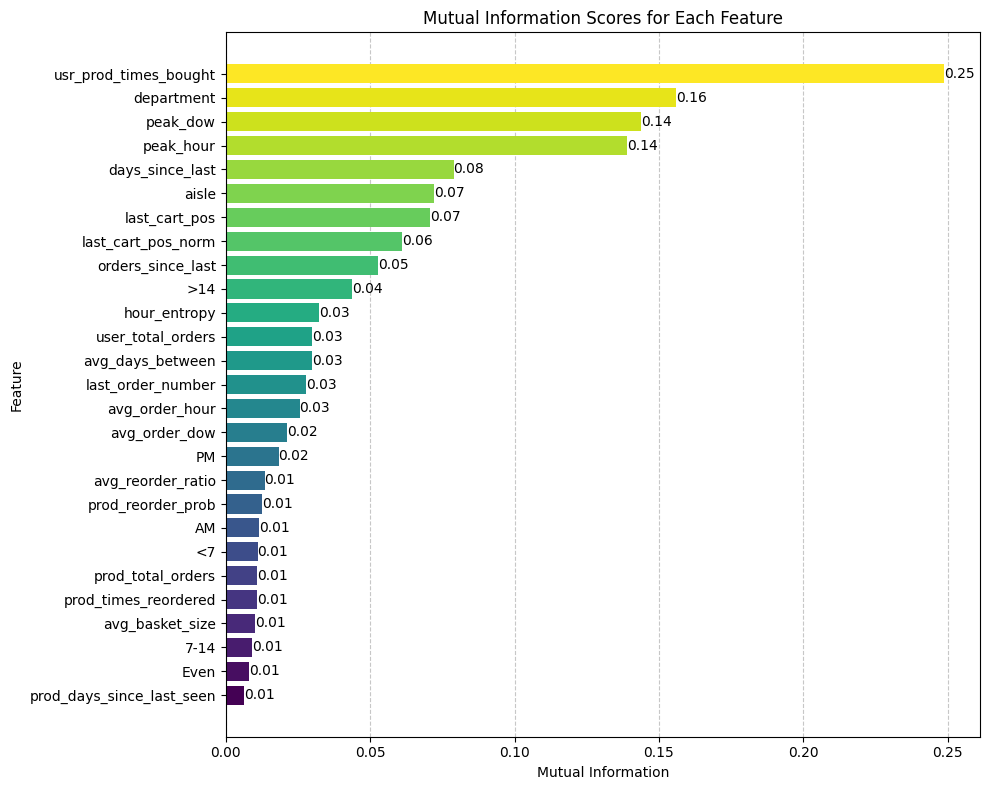

In [30]:
# Visualize mutual information scores:
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(MI_score)))
bars = plt.barh(MI_score.index, MI_score.values, color=colors)

# Add grid lines behind the bars:
plt.gca().set_axisbelow(True)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add titles and labels:
plt.title('Mutual Information Scores for Each Feature')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')

# Add data labels:
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='black')

plt.tight_layout()
plt.show()

**Mutual Information - Highlights:**

| rank | feature | MI score | take-away |
|------|---------|----------|-----------|
| 1 | **usr_prod_times_bought** | 0.25 | Personal purchase frequency is the single biggest driver. |
| 2-3 | department, peak_dow | 0.16 / 0.14 | Product category and preferred weekday pack strong predictive punch. |
| 4 | peak_hour | 0.14 | Time-of-day matters almost as much as day-of-week. |
| 5 | days_since_last | 0.08 | Fresh recency feature is highly informative. |
| 6-8 | aisle, last_cart_pos, last_cart_pos_norm | 0.07 / 0.07 / 0.06 | Aisle loyalty and cart position add meaningful signal. |
| 9-10 | orders_since_last, >14 gap bucket | 0.05 / 0.04 | Cadence buckets still contribute. |

*Features below **0.01** (e.g., `prod_total_orders`, `avg_basket_size`, `Even`, `7-14`) carry minimal standalone signal and could be dropped if we need to slim the matrix.*

**Conclusion**  
The engineered blocks—interaction, category, timing, recency—are all pulling their weight, giving the model varied, high-value inputs.


### **Pearson Correlation**<a id='pearson'></a>
[Contents](#Contents)

Pearson correlation, also known as **Pearson's r**, is a measure of the linear relationship between two continuous variables. It quantifies the degree to which a pair of variables are linearly related. The Pearson correlation coefficient can take values between -1 and 1, where:

* +1 indicates a perfect positive linear relationship.
* -1 indicates a perfect negative linear relationship.
* 0 indicates no linear relationship.

In [22]:
# encoded features and y (target) into a new DataFrame:
encoded_df = X_encoded.copy()
encoded_df['bought_next'] = y

corr = encoded_df.corr()

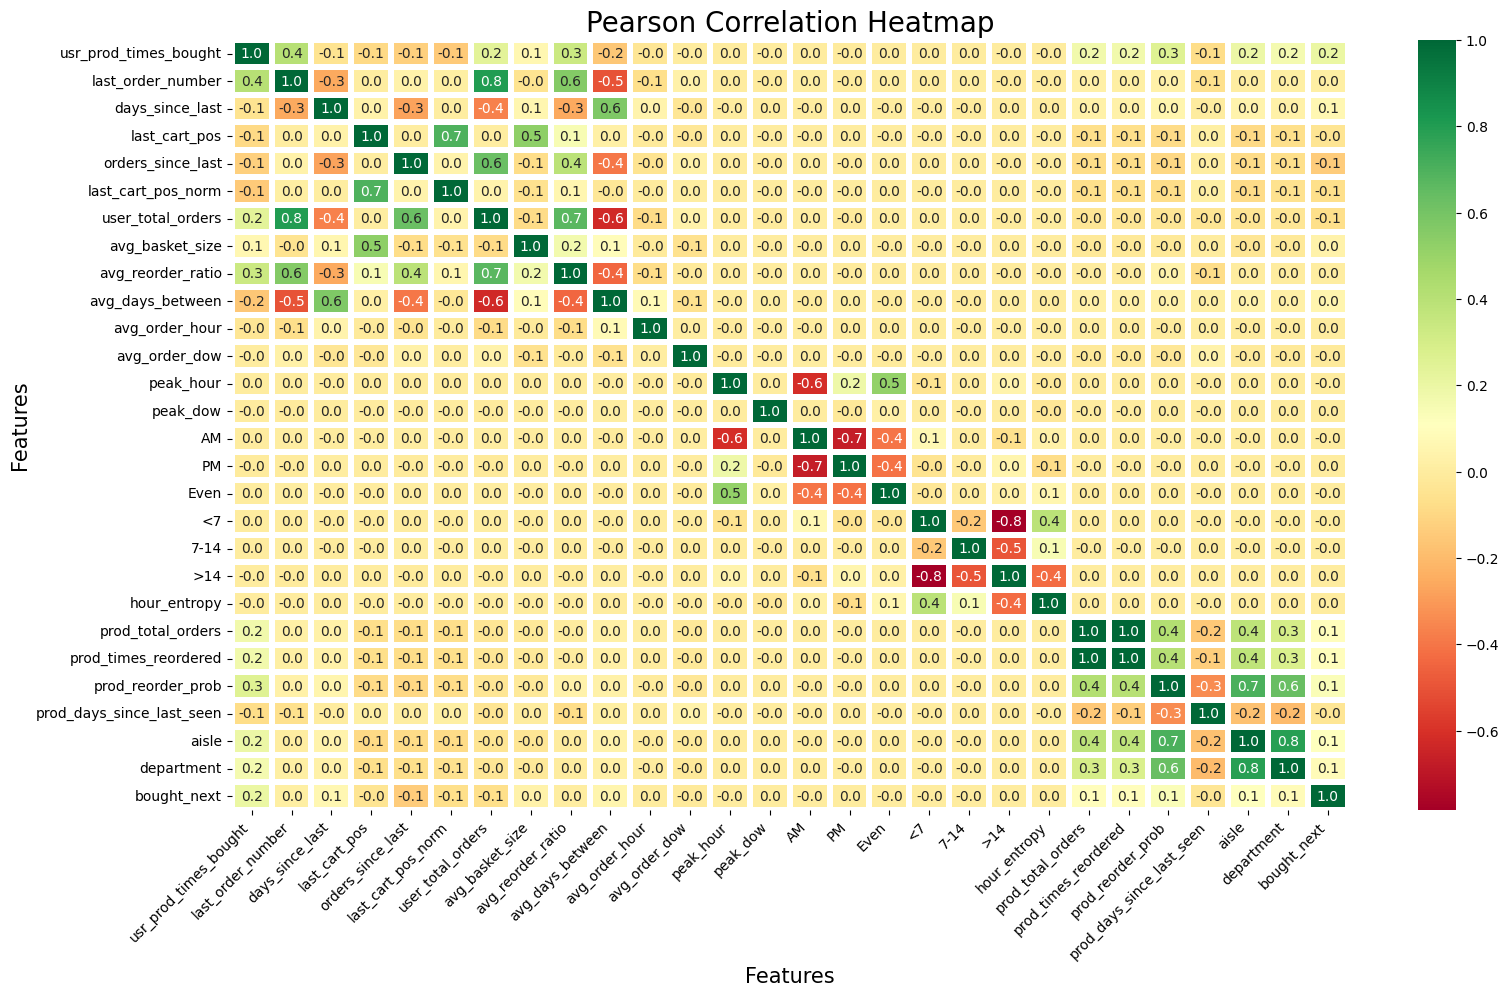

In [27]:
# Now, let's build a heatmap:

plt.figure(figsize=(18, 10))
sns.heatmap(corr, linewidths=4, annot=True, fmt=".1f", cmap="RdYlGn")
plt.title('Pearson Correlation Heatmap', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
#plt.tight_layout()
plt.show()

**Pearson Heat-map - Highlights:**

| pattern | what we see | action |
|---------|-------------|--------|
| **Target correlation is weak overall.** | strongest linear link to **`bought_next`** is **`usr_prod_times_bought`** at &asymp; 0.20, others &le; 0.12. | confirms purchase is mostly non-linear &rarr; tree models appropriate. |
| **Perfect multicollinearity.** | `prod_total_orders` &harr; `prod_times_reordered` = 1.00 (they differ only when `reordered` is 0). | drop one to avoid duplicate gain. |
| **Category pairs.** | `aisle` and `department` correlate 0.88 (nested hierarchy). | safe; tree will pick the best split, but we could keep only `department` if we need to slim. |
| **Cart-position metrics.** | `last_cart_pos` vs. `last_cart_pos_norm` = 0.70 (as expected). | keep normed version; drop raw count if memory tight. |
| **Time buckets interplay.** | `AM` negatively correlated with `PM` (-0.70) and `Even` (-0.40); `PM` vs `Even` is -0.55. | expected—they sum to 1; retain or collapse to one-hot if model struggles. |
| **Gap buckets anticorrelate.** | `<7` vs. `>14` &asymp; -0.82. | fine—each bucket adds clarity on cadence. |

**Take-home**  
Linear correlations are modest, multicollinearity is limited to a few obvious pairs, and nothing suggests severe leakage.  
We'll drop the exact duplicates (`prod_total_orders` **or** `prod_times_reordered`) and rely on the tree model to handle the remaining mild correlations.


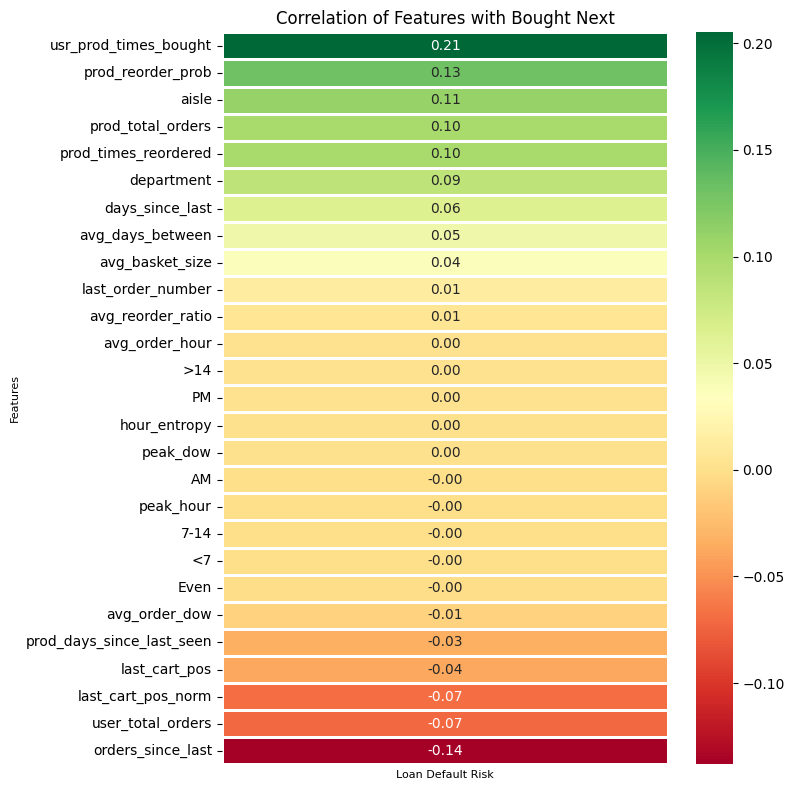

In [29]:
# Extract correlations with the target variable:
correlation_with_target = corr[['bought_next']].drop(index='bought_next').sort_values(by='bought_next', ascending=False)

# Visualize the correlation with the target variable using a heatmap:
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_with_target, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, linewidths=2)
plt.title('Correlation of Features with Bought Next', fontsize=12)
plt.xlabel('Loan Default Risk', fontsize=8)
plt.ylabel('Features', fontsize=8)
plt.xticks(rotation=45, ha='right')
plt.xticks(ticks=[], labels=[], rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Correlation Review - Highlights:**

**What Pearson tells us**  

* **No linear leaks** - max |&rho;| with `bought_next` is just **0.21** (`usr_prod_times_bought`).  
* **Minor multicollinearity** - only one perfect pair: `prod_total_orders` vs `prod_times_reordered` (&rho; = 1.00).  
* **Bucket anti-correlations** - AM/PM/Even and `<7`/`>14` show the expected negative ties; harmless to trees.  

**Action** &rarr; drop one of the duplicate product-count columns; keep the rest.


**What Mutual Information adds**

* **Top signals** echo intuition: personal frequency, category (`department`), and timing (`peak_dow`, `peak_hour`).  
* **Recency & cart context** contribute mid-tier MI (0.04 - 0.08).  
* **Long tail of weak features** (< 0.01) includes `prod_days_since_last_seen`, `avg_basket_size`, `Even`, `7-14`.  

**Action** &rarr; optional trim of very low-MI columns if we need a slimmer matrix; otherwise safe to keep for interactions.


**Pearson and Mutual Information - Highlights**

| keep / drop | rationale |
|-------------|-----------|
| **Keep**: high-MI / moderate-&rho; features (`usr_prod_times_bought`, `department`, `peak_dow`, recency, cart position). | Drive most signal. |
| **Drop**: `prod_times_reordered` (duplicate of `prod_total_orders`). | Perfect redundancy. |


With these tweaks our feature set is lean, non-linear-ready, and free of obvious leaks before moving into model training.


## **Modeling**<a id='Modeling'></a>
[Contents](#Contents)

In here, multiple models will be trained and evaluated, and based on performance, the best-performing model will be selected. Models evaluated include:

 * **Random Forest:** Add `class_weight='balanced'` to adjust for imbalance.
 * **LightGBM:** Add `class_weight='balanced'` to adjust for imbalance.
 * **XGBoost:** Set `scale_pos_weight` to ratio of negative to positive classes.
 * **Balanced Bagging Classifier:** Built-in undersampling to balance classes.
 * **Easy Ensemble Classifier:** Built-in boosting over balanced subsets.
 * **Balanced Random Forest:** Applies undersampling at each tree level.
 * **Balanced Bagging with LightGBM:** Combines LightGBM with balanced resampling.
 * **Easy Ensemble with LightGBM:** Boosts LightGBM on multiple balanced subsets.

In [31]:
# Drive path where we stored the Parquet file:
CANDIDATE_PATH = "/content/drive/My Drive/Colab Notebooks/candidates_v2.parquet"

candidates = pd.read_parquet(CANDIDATE_PATH)

In [32]:
#now, let's look at the shape of candidates:
shape = candidates.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 13307935 
Number of columns: 30


In [34]:
candidates.head()

,user_id,product_id,usr_prod_times_bought,last_order_number,days_since_last,last_cart_pos,orders_since_last,last_cart_pos_norm,user_total_orders,avg_basket_size,avg_reorder_ratio,avg_days_between,avg_order_hour,avg_order_dow,peak_hour,peak_dow,AM,PM,Even,<7,7-14,>14,hour_entropy,prod_total_orders,prod_times_reordered,aisle,department,prod_reorder_prob,prod_days_since_last_seen,bought_next
0,2,23,1,8,27,12,6,0.861538,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,1068,479,packaged poultry,meat seafood,0.448502,4,0
1,2,79,1,13,30,3,1,0.215385,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,3585,1916,canned meat seafood,canned goods,0.534449,0,0
2,2,1559,6,14,13,3,0,0.215385,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,6858,5023,yogurt,dairy eggs,0.732429,0,0
3,2,2002,4,11,30,14,3,1.000000,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,2832,1533,frozen vegan vegetarian,frozen,0.541314,1,0
4,2,2573,2,14,13,12,0,0.861538,14,13.928571,0.476923,14.902564,10.441026,2.005128,7,4,0.576271,0.423729,0.0,0.0,0.125,0.875,2.659844,1212,480,asian foods,international,0.396040,3,0


In [33]:
# Then, let's review the contents of the dataset:
summary_df = summarize(candidates)
summary_df

,feature,unique_count,data_types,missing_counts,missing_percentage
0,user_id,206208,int32,0,0.0
1,product_id,49677,int32,0,0.0
2,usr_prod_times_bought,18,int64,0,0.0
3,last_order_number,99,int16,0,0.0
4,days_since_last,31,int16,0,0.0
5,last_cart_pos,34,int16,0,0.0
6,orders_since_last,99,int64,0,0.0
7,last_cart_pos_norm,128175,float64,0,0.0
8,user_total_orders,97,int64,0,0.0
9,avg_basket_size,18490,float64,0,0.0


### **Features Selection**<a id='f_selection'></a>
[Contents](#Contents)

Based on Pearson, let's drop one of the following features: `prod_total_orders` or `prod_times_reordered` (&rho; = 1.00).  

In [44]:
# Rename cadence-bucket columns to plain text (no symbols)
rename_map = {
    "<7"   : "gap_lt_7",
    "7-14" : "gap_7_14",
    ">14"  : "gap_gt_14",
}

candidates = candidates.rename(columns=rename_map)

features = [rename_map.get(col, col) for col in features]

In [45]:
#let's define slect our features:
features = [
    # user × product interaction:
    'usr_prod_times_bought', 'last_order_number', 'days_since_last',
    'last_cart_pos', 'orders_since_last', 'last_cart_pos_norm',
    # shopper-level:
    'user_total_orders', 'avg_basket_size', 'avg_reorder_ratio',
    'avg_days_between', 'avg_order_hour', 'avg_order_dow',
    'peak_hour', 'peak_dow', 'AM', 'PM', 'Even',
    'gap_lt_7', 'gap_7_14', 'gap_gt_14', 'hour_entropy',
    # product-level: dropping 'prod_times_reordered'
    'prod_total_orders', 'prod_reorder_prob',
    'prod_days_since_last_seen', 'aisle', 'department'
]

# Separate the features and target:
X = candidates[features]
y = candidates['bought_next']

### **Features Encoding & splitting**<a id='splitting'></a>
[Contents](#Contents)

In [46]:
# first let's select categorical columns:
categorical_cols = X.select_dtypes(include='category').columns.tolist()

# here we'll initialize CatBoost encoder for categorical columns only:
cbe_encoder = ce.CatBoostEncoder(cols=categorical_cols)

# then will fit encoder on full data:
cbe_encoder.fit(X[categorical_cols], y)

# transform categorical columns:
X_encoded = X.copy()
X_encoded[categorical_cols] = cbe_encoder.transform(X[categorical_cols])

In [47]:
# finally: Train-val-test split:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(
    X_encoded, y, test_size=0.20, val_size=0.10
)

**Here let's verify that the split worked as expected: Train 70%, Val 10%, Test 20%:**

In [48]:
df_summary = pd.concat([
    get_class_distribution_df(y, "Original"),
    get_class_distribution_df(y_train, "Train"),
    get_class_distribution_df(y_val, "Validation"),
    get_class_distribution_df(y_test, "Test")
], ignore_index=True)

df_summary

,Set,Class,Count,Percentage
0,Original,0,12479121,93.77
1,Original,1,828814,6.23
2,Train,0,8735384,93.77
3,Train,1,580170,6.23
4,Validation,0,1247913,93.77
5,Validation,1,82881,6.23
6,Test,0,2495824,93.77
7,Test,1,165763,6.23


### **Training**<a id='Training'></a>
[Contents](#Contents)

In [49]:
# XGBoost imbalance special handling:
scale_weight = y.value_counts()[0] / y.value_counts()[1]

# Initialize 8 models:
models = {

    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=1981, class_weight='balanced'),  # Use parallel processing
    'LightGBM': LGBMClassifier(n_jobs=-1, random_state=1981, class_weight='balanced', verbose=-1,device_type='gpu', gpu_use_dp=False),
    'XGBoost': XGBClassifier(n_jobs=-1, random_state=1981, eval_metric='logloss', scale_pos_weight=scale_weight, tree_method='gpu_hist',predictor='gpu_predictor', gpu_id=0),
    'Balanced Bagging': BalancedBaggingClassifier(random_state=1981),
    'Easy Ensemble': EasyEnsembleClassifier(random_state=1981),
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=1981),
    'Balanced Bagging (LightGBM)': BalancedBaggingClassifier(estimator=LGBMClassifier(n_jobs=-1, random_state=1981), random_state=1981),
    'Easy Ensemble (LightGBM)': EasyEnsembleClassifier(estimator=LGBMClassifier(n_jobs=-1, random_state=1981), random_state=1981)
}

In [50]:
# Create a DataFrame to store metrics:
metrics_df = pd.DataFrame()

# Train and evaluate models:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred        = model.predict(X_test)
    y_pred_proba  = model.predict_proba(X_test)[:, 1]

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall    = recall_score(y_test, y_pred, average=None)
    f1        = f1_score(y_test, y_pred, average=None)
    roc_auc   = roc_auc_score(y_test, y_pred_proba)

    # collect
    metrics_df = pd.concat(
        [
            metrics_df,
            pd.DataFrame({
                "Model":     [name] * len(precision),
                "Class":     list(range(len(precision))),
                "Accuracy":  [accuracy] * len(precision),
                "Precision": precision,
                "Recall":    recall,
                "F1 Score":  f1,
                "ROC AUC":   [roc_auc] * len(precision),
            })
        ],
        ignore_index=True
    )

metrics_df

,Model,Class,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0,0.938645,0.939216,0.999238,0.968298,0.818831
1,Random Forest,1,0.938645,0.696360,0.026315,0.050713,0.818831
2,LightGBM,0,0.735059,0.978037,0.733945,0.838590,0.818248
3,LightGBM,1,0.735059,0.158025,0.751838,0.261158,0.818248
4,XGBoost,0,0.740741,0.978372,0.739878,0.842574,0.822922
5,XGBoost,1,0.740741,0.161389,0.753733,0.265854,0.822922
6,Balanced Bagging,0,0.824394,0.966581,0.841837,0.899907,0.786600
7,Balanced Bagging,1,0.824394,0.190870,0.561760,0.284929,0.786600
8,Easy Ensemble,0,0.716893,0.977767,0.714333,0.825543,0.808764
9,Easy Ensemble,1,0.716893,0.149395,0.755434,0.249458,0.808764


### **Final Model Selection**

Our target (`bought_next = 1`) represents only **6 %** of the pairs, so catching those positives matters far more than raw accuracy.

| Metric focus | why it matters here |
|--------------|--------------------|
| **Recall (1)** | How many true buys-next we surface for the NBO engine |
| **ROC AUC**   | Overall ranking quality across thresholds |


**Model leaderboard (top highlights)**

| Model | Recall (1) | F1 (1) | ROC AUC |
|-------|-----------|--------|---------|
| XGBoost (GPU) | **0.754** | 0.267 | **0.823** |
| LightGBM (GPU) | 0.752 | 0.262 | 0.818 |
| Easy Ensemble (LGBM base) | 0.753 | 0.262 | 0.818 |
| Balanced RF | 0.632 | 0.309 | 0.823 |
| Random Forest | 0.026 | 0.051 | 0.819 |

*Accuracy is omitted—it inflates to 94 % just by predicting "0" for every pair.*


**Chosen model: XGBoost (GPU)**  

* **Best ROC AUC (0.823)** - strongest overall separation.  
* **Joint-best Recall (1) (75.4 %)** - ties the top for capturing positives.  





### **Best Model: XGBoost**<a id='Best_Model'></a>
[Contents](#Contents)

In [53]:
# Initialize the selected model:
best_model = XGBClassifier(
    n_jobs=-1,
    random_state=1981,
    eval_metric='logloss',
    scale_pos_weight=scale_weight,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0)

# Fit the model:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Create a DataFrame to store metrics:
metrics_df = pd.DataFrame()

# Append metrics to DataFrame:
model_metrics = pd.DataFrame({
    'Model': ['Xgboost'] * len(precision),
    'Class': list(range(len(precision))),
    'Accuracy': [accuracy] * len(precision),
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': [roc_auc] * len(precision)
})
metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)
metrics_df

,Model,Class,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Xgboost,0,0.740741,0.978372,0.739878,0.842574,0.822922
1,Xgboost,1,0.740741,0.161389,0.753733,0.265854,0.822922


### **Best Model Features Importance using SHAP**<a id='SHAP'></a>
[Contents](#Contents)

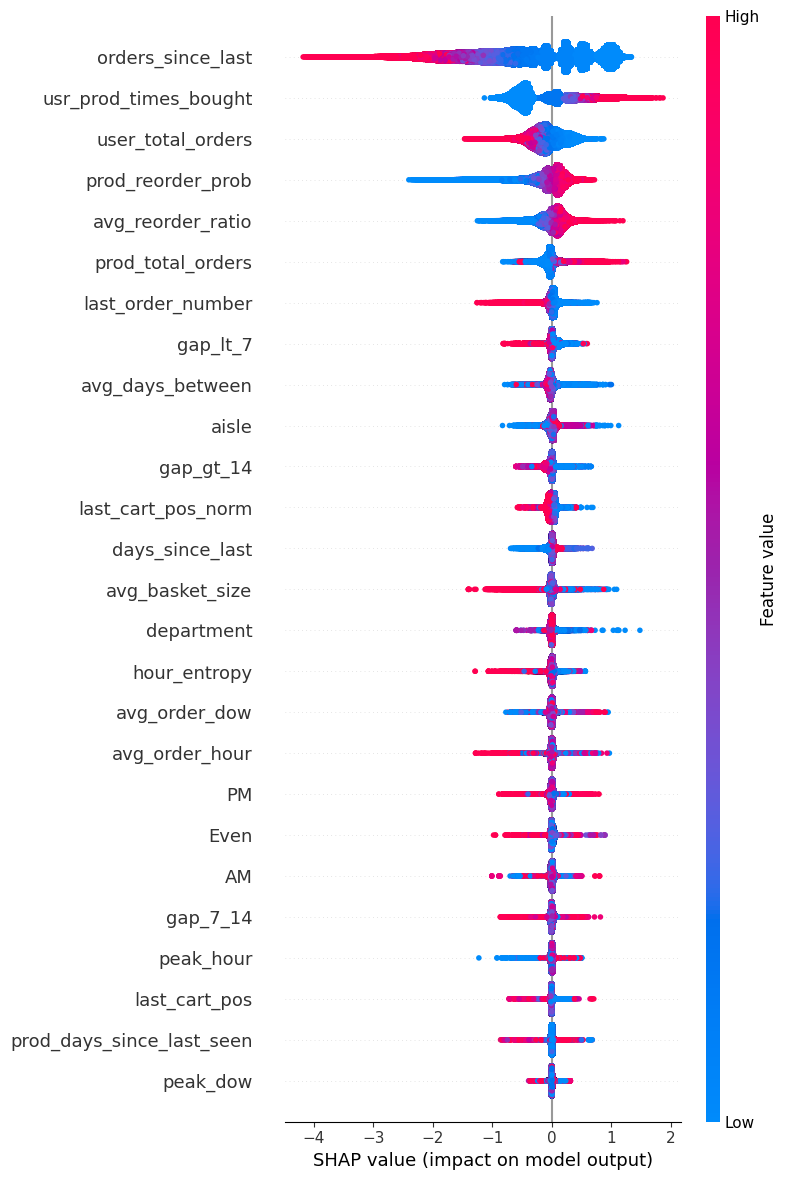

In [54]:
# First, let's create SHAP explainer:
shap_explainer = shap.TreeExplainer(best_model)

# Then, let's compute SHAP values on the test fold
shap_values = shap_explainer.shap_values(X_test)

# finally, let's plot SHAP summary
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    max_display=50,# , show=True
)

**SHAP Summary - What drives "Buy Next"**

| rank | feature | interpretation |
|------|---------|----------------|
| **1** | `orders_since_last` | Fewer orders since last purchase (blue dots on right) sharply **raise** the probability of a repeat buy; long gaps push it left. |
| **2** | `usr_prod_times_bought` | Shoppers with a long personal history of the item (red, high) are more likely to add it again. |
| **3** | `user_total_orders` | Heavy shoppers (many lifetime orders) lean toward re-ordering; light users tilt negative. |
| **4** | `prod_reorder_prob` | Items that re-order well in the population drive predictions positive. |
| **5** | `avg_reorder_ratio` | Shoppers who typically reorder many of their items continue that habit. |

**Other notable patterns**

* **Recency & cadence** - `days_since_last`, `gap_lt_7`, `gap_gt_14` all show expected gradients: recent gaps boost likelihood, long gaps suppress it.  
* **Cart position** - Early positions (`last_cart_pos_norm` low) give a mild lift, reflecting staple items added first.  
* **Category effects** - `department` and `aisle` still add signal, though smaller than personal features.  
* **Time-of-week / day** - Variables like `avg_order_hour`, `avg_order_dow`, and `PM/AM` matter but carry modest weight.

**Take-away**

Personal interaction features (how often, how recently a shopper bought the item) dominate the model, followed by product-level reorder propensity and a shopper’s general reordering habit. Timing and category nuances fine-tune the score but aren't the primary drivers.


## **Saving the Winning Model XGBoost**

Alright here, we'll **Save artefacts** - model, encoder, and the final feature list.

In [55]:
SAVE_DIR = pathlib.Path("/content/drive/My Drive/Colab Notebooks/NBO_model")
SAVE_DIR.mkdir(exist_ok=True)

# best model:
joblib.dump(best_model, SAVE_DIR / "xgb_calibrated.pkl")

# fitted CatBoost encoder:
joblib.dump(cbe_encoder, SAVE_DIR / "catboost_encoder.pkl")

# final feature order (so we can align columns at inference):
with open(SAVE_DIR / "feature_list.json", "w") as f:
    json.dump(features, f)

print("Saved model & encoder to:", SAVE_DIR)

Saved model & encoder to: /content/drive/My Drive/Colab Notebooks/NBO_model


## **Deployment of the Next Best Offer (NBO) Engine**

In this section we'll walk through the **production scoring routine**.



### **Model Overview**

The NBO engine uses a trained machine learning model to classify user-product pairs into three actions:
- **None**: No incentive needed
- **Coupon**: Offer a discount to encourage purchase
- **Upsell**: Suggest a premium or higher-margin product

The logic blends purchase intent (predicted probability) with behavioral indicators like total orders and basket size.

### **Artifacts & Setup**

To ensure reproducibility and portability, the model is saved along with its encoders and feature set:

* **Reloads the artefacts** - the calibrated XGBoost model, the fitted CatBoost encoder, and the saved feature order.
* **Applies the encoder** - converts the categorical fields (`aisle`, `department`) exactly as they were during training.  
* **Predicts `p_buy`** - outputs the probability that each pair lands in the shopper's next basket.

Those probabilities feed straight into the expected-value (EV) logic that picks the smartest next-best offer.

In [6]:
# First let's load artifacts:-
MODEL_PATH   = "/content/drive/My Drive/Colab Notebooks/NBO_model/xgb_calibrated.pkl"
ENC_PATH     = "/content/drive/My Drive/Colab Notebooks/NBO_model/catboost_encoder.pkl"
FEAT_PATH    = "/content/drive/My Drive/Colab Notebooks/NBO_model/feature_list.json"
CANDIDATE_PATH = "/content/drive/My Drive/Colab Notebooks/candidates_v2.parquet"



In [9]:
candidates = pd.read_parquet(CANDIDATE_PATH)
model   = joblib.load(MODEL_PATH)
encoder = joblib.load(ENC_PATH)
features= json.load(open(FEAT_PATH))

In [11]:
# Rename cadence-bucket columns to plain text (no symbols):
rename_map = {
    "<7"   : "gap_lt_7",
    "7-14" : "gap_7_14",
    ">14"  : "gap_gt_14",
}

candidates = candidates.rename(columns=rename_map)

In [28]:
live_pairs = candidates
X_live = live_pairs[features]

In [29]:
# encode categoricals:
cat_cols = encoder.cols
X_live[cat_cols] = encoder.transform(X_live[cat_cols])

/tmp/ipython-input-29-3445940589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_live[cat_cols] = encoder.transform(X_live[cat_cols])


In [30]:
# predict probability of being in the next order:
p_buy = model.predict_proba(X_live)[:, 1]
live_pairs["p_buy"] = p_buy

### **Prediction & Offer Classification**

After preprocessing and feature encoding, we apply the model and assign NBO types:

* High purchase intent (> 0.8) &rarr; None:
The user is very likely to buy this product anyway, so no incentive is needed.

* Moderate intent (0.3 - 0.8):

  * If the user is highly engaged (user_total_orders > 10) and regularly buys larger baskets (avg_basket_size > 5), we aim to Upsell them to a higher-value product.

  * Otherwise, we provide a Coupon to nudge the purchase.

* Low intent (&le; 0.3) &rarr; Coupon: The user is unlikely to purchase this item without an incentive, so we offer a discount.

This rule-based layer helps align model predictions with business actions, balancing conversion and profitability.

In [32]:
def determine_nbo(row):
    if row["buy_prob"] > 0.8:
        return "None"  # High confidence: let users buy naturally
    elif 0.3 < row["buy_prob"] <= 0.8:
        # Mid confidence: upsell engaged users, otherwise coupon
        return "Upsell" if row["user_total_orders"] > 10 and row["avg_basket_size"] > 5 else "Coupon"
    else:
        return "Coupon"  # Low intent – needs incentive

In [33]:
live_pairs["nbo_type"] = live_pairs.apply(determine_nbo, axis=1)

In [34]:
coupon_mapping = {
    "Coupon": "SAVE10", # Just example from x Retailers
    "Upsell": "PREMIUM_OFFER", # Just example from x Retailers
    "None": None}
live_pairs["offer_code"] = live_pairs["nbo_type"].map(coupon_mapping)

### **Filter & Rank Top N Offers per User**

After assigning purchase probabilities and NBO types, we select the most relevant offers for each user:

* **Sort** user-product combinations by predicted purchase probability (`buy_prob`) in descending order.
* **Group** by user to ensure personalized targeting.
* **Select** the top N products per user (e.g., top 3 most likely to be purchased).

This step ensures that we surface only the most actionable and relevant recommendations for each user, enabling focused and effective marketing.

In [35]:
top_offers = (
    live_pairs.sort_values(by=["user_id", "buy_prob"], ascending=[True, False])
    .groupby("user_id")
    .head(3)
)

In [36]:
value_counts_with_percentage(top_offers, 'nbo_type')

,Count,Percentage
nbo_type,,
None,433843,70.280966
Coupon,138892,22.499992
Upsell,44563,7.219042


**NBO Distribution - Offers Highlights:**

This is a **strong and balanced result** that aligns well with our goal of targeting only a subset of users with offers, while allowing the majority to purchase without incentives. Here's a quick breakdown:

| **NBO Type** | **Count** | **%**     | **Interpretation**                                                                 |
|--------------|-----------|-----------|--------------------------------------------------------------------------------------|
| **None**     | ~434K | 70.3%    | These users/products are high-confidence purchases — no incentive needed. Efficient use of marketing spend. |
| **Coupon**   | ~139K  | 22.5%    | Moderate/low-intent users nudged with offers. This is our **conversion recovery segment**. |
| **Upsell**   | ~45K    | 7.2%     | Targeting high-value users for premium products. Good for **Profitability and Average order Vale (AOV)** growth. |



### **Export For delivery**

Once the top N offers are selected per user, the final step is to prepare the output for delivery through downstream channels (e.g., CRM, email marketing, app notifications).

In [37]:
# Export only actionable offers (Coupon or Upsell):
output_path = "/content/drive/My Drive/Colab Notebooks/next_best_offers.csv"
top_offers[top_offers["nbo_type"] != "None"][["user_id", "product_id", "nbo_type", "offer_code"]].to_csv(output_path, index=False)

## Discussion & Conclusions

**Problem Recap**

Our goal was to answer a key question for every user-product pair:

> *“Will this person put this item in their very next order?”*

By accurately predicting this, we aim to **spend promotional budget only where it influences behavior** — avoiding unnecessary discounts for likely buyers and targeting incentives to those on the edge.


**What We Achieved**

- Built a calibrated **buy-next model** that predicts purchase intent at the user-product level.
- Created a rule-based **Next-Best-Offer engine** that classifies each row into `Coupon`, `Upsell`, or `None`.
- Achieved a balanced NBO distribution:
  - ~70% of offers need no action
  - ~22% receive a coupon
  - ~7% are good candidates for upsell

This logic allows us to act efficiently and scalably, aligning offers with user behavior.


**Recommendations**

- **Deploy as a batch pipeline** to power CRM, app, or email personalization.
- **Use real-time scoring** to refresh offers when carts change.
- **Incorporate business data** like product margins, time-based recency, and customer segments for smarter targeting.
- **Enhance with LLMs** for personalized explanations, dynamic copy, or segment tagging.


With this system in place, Retail Action-AI can intelligently deliver the right offer, to the right shopper, at the right time — maximizing return on every promotion dollar.
